In [1]:
import os
import pandas as pd
import numpy as np
import time
import re
import codecs
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import datetime
from scipy.spatial.distance import cosine

nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jinwoo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Import data

### Please change the directories based on your local machine

In [2]:
#Please change directories based on your local machine
base_dir = os.path.join(os.getcwd(),'data')
preprocessed_dir = os.path.join(base_dir,'preprocessed','lemmatized')

lexicon_dir = os.path.join(base_dir,'lexicon')
conflict = pd.read_excel(os.path.join(lexicon_dir,'enh_conflict_lexicon.xlsx'))
peace = pd.read_excel(os.path.join(lexicon_dir,'enh_peace_lexicon.xlsx'))
resilence = pd.read_excel(os.path.join(lexicon_dir,'enh_resilience_lexicon.xlsx'))


#Please designate the save directory of csv and image file
output_csv_dir = os.path.join(base_dir,'preprocessed')

In [3]:
country_dir = os.path.join(preprocessed_dir,'HK')
print(country_dir)

C:\Users\jinwoo\0.JupyterNotebook\1. Captsone Project\2. Matt Github\data\preprocessed\lemmatized\HK


In [4]:
#Read Files from local machine
start_time = datetime.datetime.now()
df_dict_country = {"id": [], "title": [], "publisher": [], "article_text":[],"url":[], "path":[]}
for entry_publisher in os.scandir(country_dir):
    for entry_year in os.scandir(entry_publisher.path):
        for entry_final in os.scandir(entry_year.path):
            try:
                with open(entry_final, "r") as f:
                    article_id = f.readline().strip()
                    article_title = f.readline().strip()
                    publisher = f.readline().strip()
                    url = f.readline()
                    f.readline()
                    f.readline()
                    article_text = f.readline().strip()
                    df_dict_country['url'].append(url)
                    df_dict_country['id'].append(article_id)
                    df_dict_country['title'].append(article_title)
                    df_dict_country['publisher'].append(publisher)
                    df_dict_country['article_text'].append(article_text)
                    df_dict_country['path'].append(entry_final.name)
            except:
                pass
end_time = datetime.datetime.now()

In [5]:
#time taken for reading one country
end_time - start_time

datetime.timedelta(microseconds=357073)

In [6]:
df_dict_country = pd.DataFrame.from_dict(df_dict_country)

In [7]:
df_dict_country

,id,title,publisher,article_text,url,path
0,13517304,Toyota Motor Thailand Revises Thailand Car Sal...,ACN Newswire (press release),bangkok july jcn newswire toyota motor thailan...,http://en.acnnewswire.com/press-release/englis...,13517304_HK_26-07-16.txt
1,13642498,Fujitsu Creates One of Europe's Biggest Servic...,ACN Newswire (press release),public cloud platform continue new growth area...,http://en.acnnewswire.com/press-release/englis...,13642498_HK_02-08-16.txt
2,14204012,"Mars, Incorporated announced as Spikes Asia Ad...",ACN Newswire (press release),singapore sept acn newswire spike asia today a...,http://en.acnnewswire.com/press-release/englis...,14204012_HK_05-09-16.txt
3,14270310,IBDExpo 2016 to Accelerate Indonesia's Busines...,ACN Newswire (press release),ibdexpo international trade exhibition design ...,http://en.acnnewswire.com/press-release/englis...,14270310_HK_08-09-16.txt
4,14354286,NEC Demonstrates Transport Technology and Solu...,ACN Newswire (press release),tokyo sept jcn newswire nec corporation tse to...,http://en.acnnewswire.com/press-release/englis...,14354286_HK_14-09-16.txt
...,...,...,...,...,...,...
5065,10305109,"Step Aside, IKEA: China's Stock-Trading Halls ...",Wall Street Journal,nvestors playng card shangha stock tradng hall...,http://blogs.wsj.com/chinarealtime/2016/02/16/...,10305109_HK_15-02-16.txt
5066,7837939,"Once Bitten, Twice Shy: Zhou Xiaochuan Didn't ...",Wall Street Journal,zhou xaochuan governor people 's bank chna lst...,http://blogs.wsj.com/chinarealtime/2016/03/22/...,7837939_HK_22-03-16.txt
5067,8212433,Field of Dreams: China Aims to Become 'Top-Qua...,Wall Street Journal,n th march fle photo student take part n socce...,http://blogs.wsj.com/chinarealtime/2016/04/12/...,8212433_HK_12-04-16.txt
5068,8709245,Maoist Overtones in Beijing Concert Raise Red ...,Wall Street Journal,recent concert featurng maost red song stag n ...,http://blogs.wsj.com/chinarealtime/2016/05/08/...,8709245_HK_08-05-16.txt


## Word Frequency Analysis with visualization

create_vocab_dict: creates the vocab dictionary based on the lexicons from *peace*, *conflict*, *resilence*; have only counted lexicons less than 5 words (4-gram max)

word_freq: uses Countvectorizer to creates the dictionary with word counts {str(word):int(count)}

plot_n_most_common_words: using the dictionary with word counts, output the graph with given integer n.

In [8]:
conflict['label'] = 'conflict'
peace['label'] = 'peace'
resilence['label'] = 'resilence'
conflict = conflict.loc[:,['Term', 'label']]
peace['Term'] = peace['academic freedom']
peace = peace.loc[:,['Term', 'label']]
resilence = resilence.loc[:,['Term', 'label']]

vocab_df = conflict.copy()
vocab_df = vocab_df.append(peace)
vocab_df = vocab_df.append(resilence)
vocab_df.index = np.arange(0, len(vocab_df))

In [9]:
#Create dictionary for the vocab in CountVectorizer
def create_vocab_dict(vocab_df):
    vocabs = vocab_df.Term.str.lower()
    vocabs = list(set(vocabs))
    vocab_dictionary = {}
    idx = 0
    for vocab in vocabs:
        voc_len = len(word_tokenize(vocab))
        if voc_len < 5:
            vocab_dictionary[vocab] = idx
            idx += 1
    return vocab_dictionary

In [10]:
#Using Countvectorizer to count all the n-grams
def word_freq(df, vocab_dictionary):
    count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,4), vocabulary=vocab_dictionary)
    count_data = count_vectorizer.fit_transform(df.article_text)
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
  
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key = lambda x:x[1], reverse = True)

    return count_dict

In [11]:
def plot_n_most_common_words(count_dict, n):
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title= str(n) + ' most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    plt.savefig('elbow_method.jpg', bbox_inches='tight', dpi=500)

### Create Word Freq

If you have used different columns for cleaned_text, please add another column or change the column name to text.

In [12]:
vocab_dictionary = create_vocab_dict(vocab_df)

In [13]:
df_dict_country['text'] = df_dict_country['article_text']
start_time = datetime.datetime.now()
count_dict= word_freq(df_dict_country, vocab_dictionary)
end_time = datetime.datetime.now()

In [14]:
#Time taken for creating count_dict
end_time - start_time

datetime.timedelta(seconds=4, microseconds=26849)

C:\Users\jinwoo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


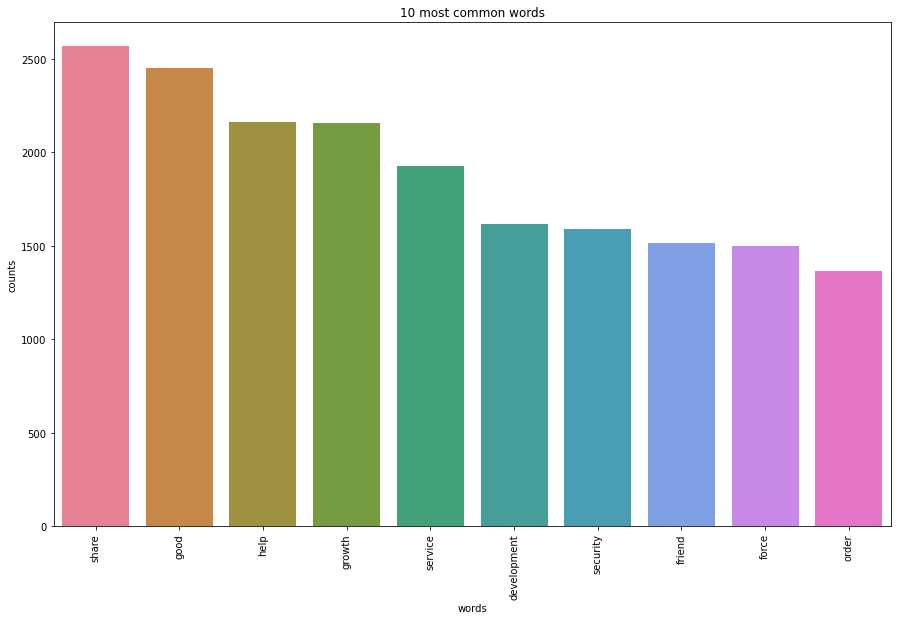

<Figure size 432x288 with 0 Axes>

In [15]:
plot_n_most_common_words(count_dict, 10)

## Export


#### The country_directory should be in the form of .../COUNTRY_CODE_IN_TWO_ALPHABET.
One can change the country_name part (hard-code) in the below funciton

In [16]:
#expects the country_directory to be written as .../COUNTRY_CODE
country_name =  country_dir[-2:]

In [17]:
def create_countdict_df(count_dict, vocab_df, save_dir, country_name):
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    
    df_count_dict = pd.DataFrame(words,columns = ['Term'])
    df_count_dict['count'] = counts
    df_count_dict['nation'] = country_name
    
    vocab_df['Term_lower'] = vocab_df.Term.str.lower()
    label_dictionary_lower = dict(zip(vocab_df['Term_lower'], vocab_df['label']))
    og_term_dictionary = dict(zip(vocab_df['Term_lower'], vocab_df['Term']))
    
    df_count_dict['label'] = ''
    df_count_dict['Original_Term'] = ''
    for i in range(len(df_count_dict)):
        df_count_dict['label'][i] = label_dictionary_lower[df_count_dict['Term'][i]]
        df_count_dict['Original_Term'][i] = og_term_dictionary[df_count_dict['Term'][i]]
    
    return df_count_dict

In [18]:
def save_plot(count_dict, n, save_dir, country_name):
    
    img_dir = os.path.join(save_dir, country_name + '.jpg')
    
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title= str(n) + ' most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    
    plt.savefig(img_dir, bbox_inches='tight', dpi=500)

<ipython-input-17-84b463629c14>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_count_dict['label'][i] = label_dictionary_lower[df_count_dict['Term'][i]]
<ipython-input-17-84b463629c14>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_count_dict['Original_Term'][i] = og_term_dictionary[df_count_dict['Term'][i]]
C:\Users\jinwoo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

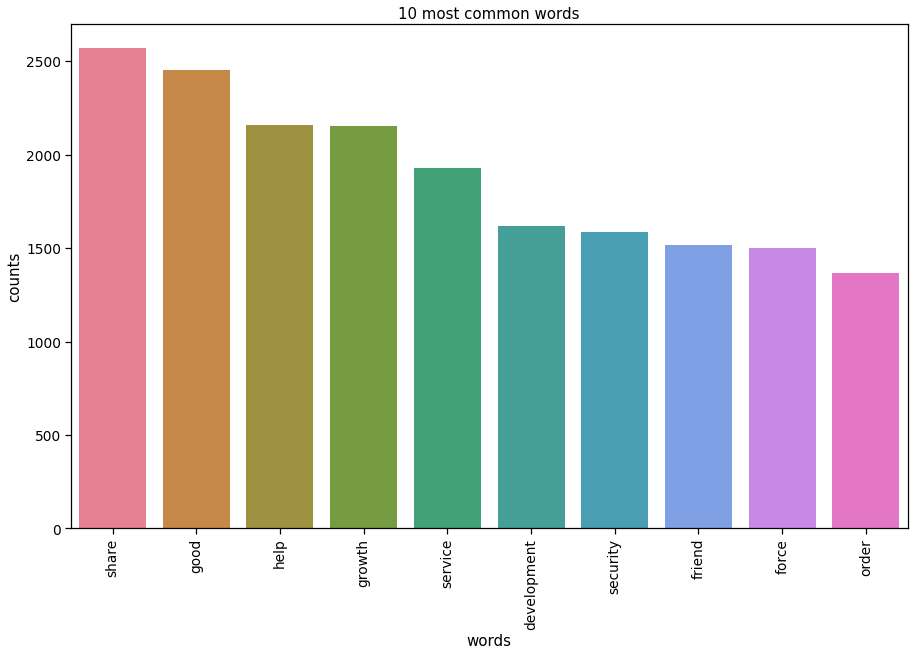

In [19]:
df_test = create_countdict_df(count_dict = count_dict, vocab_df = vocab_df,save_dir =  output_csv_dir, country_name = country_name)
df_test.to_csv(os.path.join(output_csv_dir, country_name + '.csv'))
save_plot(count_dict, 10,  output_csv_dir, country_name)